# TP Estadística e Inferencia II - Parte 1

In [126]:
from sklearn.datasets import load_iris
import pandas as pd
import seaborn as sns
import matplotlib . pyplot as plt
import pymc as pm
import arviz as az
import numpy as np
import preliz as pz

## Parte 1: Análisis exploratorio de datos (EDA)

1. **Carga y descripción del dataset**  
+ Cargar el dataset Iris.  
+ Identificar las variables (numéricas y categóricas).  
+ Describir brevemente cada variable (nombre, tipo y rango).

In [38]:
iris = load_iris(as_frame=True).frame
iris['species'] = iris['target'].map({0: 'setosa', 1: 'versicolor', 2: 'virginica'})
iris.drop(columns=['target'], inplace=True)

In [39]:
iris.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   species            150 non-null    object 
dtypes: float64(4), object(1)
memory usage: 6.0+ KB


Las variables númericas son las relacionadas con las mediciones de las flores:
+ ``sepal length (cm)``
+ ``sepal width (cm)``
+ ``petal length (cm)``
+ ``petal width (cm)``

Mientras que la única variable categorica es ``target`` y ``species`` (son la misma columna mapeada).

2. **Estadísticas descriptivas:**  
+ Calcular media, mediana, desviación estándar y rangos para cada variable numérica.
+ Realizar la tabla de frecuencia de las especies.

In [40]:
iris.describe(exclude=[int, object])

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm)
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333
std,0.828066,0.435866,1.765298,0.762238
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [41]:
iris.species.value_counts().to_frame()

,count
species,
setosa,50
versicolor,50
virginica,50


3. **Visualización univariada**
+ Graficar histogramas o densidades de cada variable numérica diferenciando por especie.

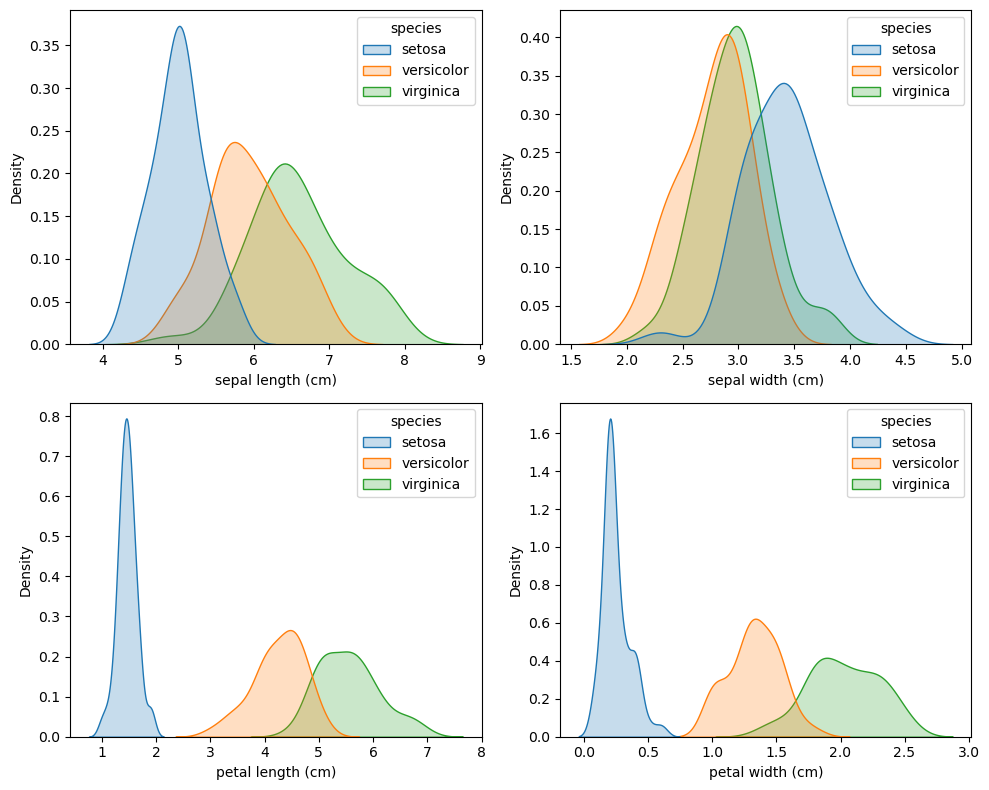

In [42]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8))
sns.kdeplot(data=iris, x='sepal length (cm)', hue='species', ax=axes[0, 0], fill=True)
sns.kdeplot(data=iris, x='sepal width (cm)', hue='species', ax=axes[0, 1], fill=True)
sns.kdeplot(data=iris, x='petal length (cm)', hue='species', ax=axes[1, 0], fill=True)
sns.kdeplot(data=iris, x='petal width (cm)', hue='species', ax=axes[1, 1], fill=True)
plt.tight_layout();

+ ``sepal length``: Virginica tiene generalmente valores más altos que Versicolor que a su vez suele superar a Setosa en esta medida.  
+ ``sepal width``: Virginica y Versicolor poseen valores similares y Setosa suele tener un sépalo más ancho.
+ ``petal length``: Setosa suele tener el pétalo más corto y con poca varianza (suele medir entre 1 y 2 cm). Versicolor y Virginica tienen varianzas similares, con los pétalos de Virginica siedo generalmente más largos.
+ ``petal width``: Las distribuciones son muy similares a la anterior.

4. **Visualización bivariada**
+ Graficar _scatter plots_ (o _pair plots_) entre pares de variables numéricas.
+ Colorear por especie para ver la separación entre clases

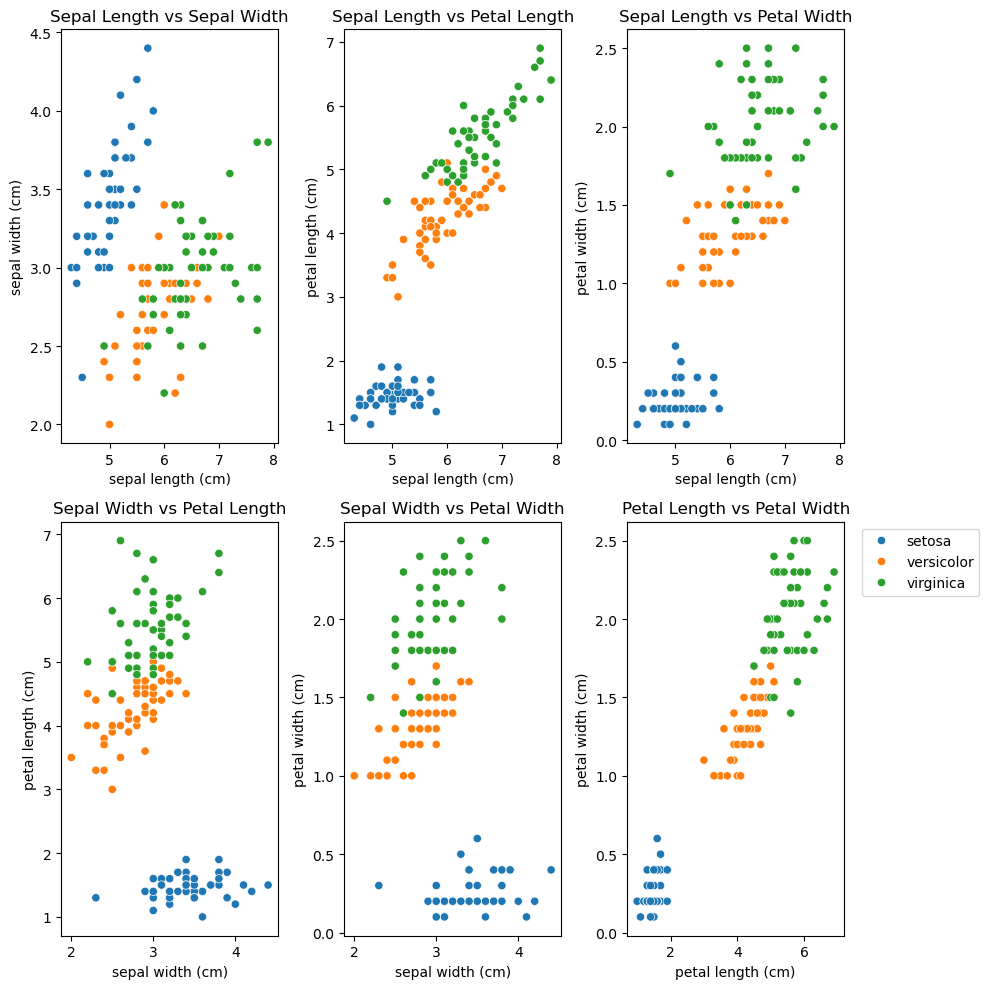

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(10, 10))
sns.scatterplot(data=iris, x='sepal length (cm)', y='sepal width (cm)', hue='species', ax=axes[0, 0], legend=False)
sns.scatterplot(data=iris, x='sepal length (cm)', y='petal length (cm)', hue='species', ax=axes[0, 1], legend=False)
sns.scatterplot(data=iris, x='sepal length (cm)', y='petal width (cm)', hue='species', ax=axes[0, 2], legend=False)
sns.scatterplot(data=iris, x='sepal width (cm)', y='petal length (cm)', hue='species', ax=axes[1, 0], legend=False)
sns.scatterplot(data=iris, x='sepal width (cm)', y='petal width (cm)', hue='species', ax=axes[1, 1], legend=False)
sns.scatterplot(data=iris, x='petal length (cm)', y='petal width (cm)', hue='species', ax=axes[1, 2])
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
axes[0, 0].set_title('Sepal Length vs Sepal Width')
axes[0, 1].set_title('Sepal Length vs Petal Length')
axes[0, 2].set_title('Sepal Length vs Petal Width')
axes[1, 0].set_title('Sepal Width vs Petal Length')
axes[1, 1].set_title('Sepal Width vs Petal Width')
axes[1, 2].set_title('Petal Length vs Petal Width')
plt.tight_layout();

5. **Análisis preliminar**
+ Identificar si hay variables más discriminantes entre especies.
+ Comentar relaciones visibles entre variables y especies

Responder

## Parte 2: Modelos Bayesianos
A) Modelo bayesiano no jerárquico

6. Elegir una variable numérica (por ejemplo, Sepal.Length).

In [44]:
sepal_length_data = iris['sepal length (cm)'].values

7. Asumir que los valores de esa variable, para cada especie, provienen de una distribución Normal con media y desviación específicas para cada especie:

$$ y_{ij} \sim \mathcal{N}(\mu_j, \sigma_j^2) $$


Asumimos que, para cada especie setosa ,versicolor,virginica,
la variable **Sepal.Length** sigue:

$$
y_{ij} \sim N(\mu_j, \sigma_j^2), \quad i = 1, \dots, n_j
$$

donde

- (mu_j): media de **Sepal.Length** para la especie \( j \)
- (sigma_j): desvío estándar dentro de la especie \( j \)



8. Especificar priors independientes para μj y σj

En este modelo asumimos que, para cada especie, las longitudes de sépalo siguen una distribución normal con una media y una desviación estándar propias.  
Es decir, cada observación dentro de la especie *j* se modela como:

$$
y_{ij} \sim \mathcal{N}(\mu_j, \sigma_j^2)
$$

Para los parámetros usamos **priors independientes** en cada especie:

- **Medias** ($\mu_j$): se modelan con una distribución Normal centrada en 5.5 y con una desviación estándar de 2.  
  Esto refleja un conocimiento previo razonable sobre el rango de longitudes de sépalo y, al mismo tiempo, deja suficiente flexibilidad para que los datos ajusten los valores finales.

- **Desviaciones estándar** ($\sigma_j$): se modelan con un prior $\text{HalfNormal}(1)$, que asegura valores positivos y además es más realista respecto a la variabilidad que muestran los datos del iris (en general entre 0.3 y 0.5 cm).

En conjunto, estos priors son **débiles pero informativos**, lo que significa que guían el modelo hacia valores plausibles sin imponer restricciones fuertes.


9. Implementar el modelo con PyMC y extraer muestras posteriores de μj y σj

In [ ]:
categories = np.array(["setosa", "versicolor", "virginica"])

idx = pd.Categorical(iris["species"], categories=categories).codes

coords = {"species": categories, "species_flat": categories[idx]}

In [84]:
with pm.Model(coords=coords) as non_hier_model:
    # Priors de medias independientes
    mu_species = pm.Normal("mu_species", mu=5.5, sigma=2, dims="species")

    # Priors de desviaciones estándar independientes
    sigma = pm.HalfNormal("sigma", sigma=1, dims="species")

    # Likelihood: cada dato usa el mu y sigma de su especie
    y_obs = pm.Normal("y_obs", mu=mu_species[idx], sigma=sigma[idx], observed=sepal_length_data, dims="species_flat")

    # Muestreo posterior
    trace_no_j = pm.sample(2000, chains=4)

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_species, sigma]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 37 seconds.


10. Graficar distribuciones posteriores de las medias por especie y comparar con los
valores observados.

Visualizamos las distribuciones posteriores de las medias ($\mu_j$) para cada especie y las compararemos con las medias observadas en los datos originales. Esto nos dará una idea de la inferencia que el modelo ha hecho sobre los valores centrales de la longitud del sépalo para cada grupo.

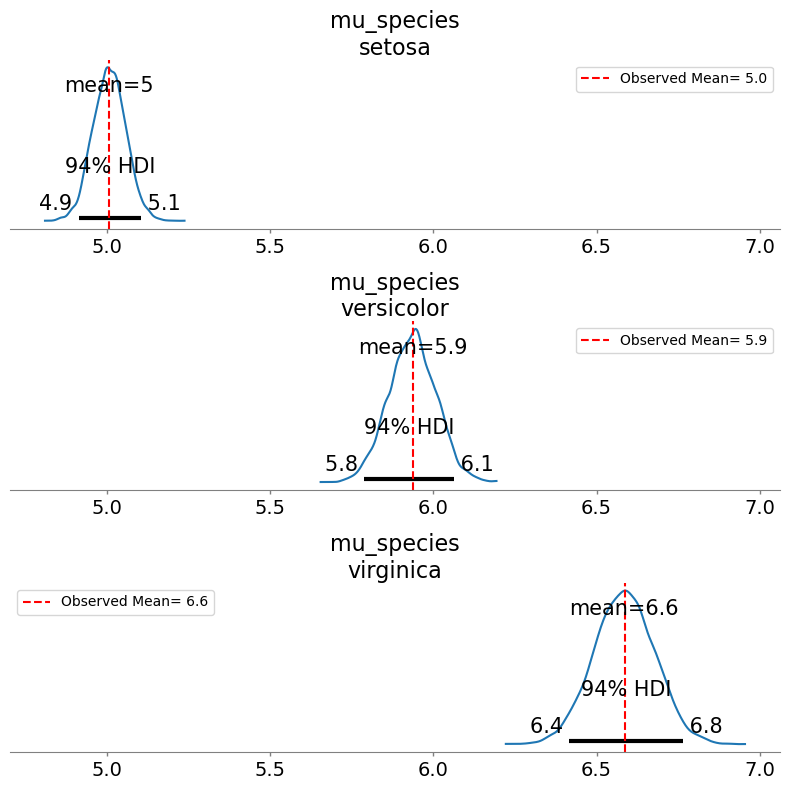

In [94]:
# Medias observadas por especie
observed_means = iris.groupby("species")["sepal length (cm)"].mean()

# Graficar las distribuciones posteriores
fig, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

for i, species in enumerate(categories):
    ax = axes[i]
    az.plot_posterior(trace_no_j, var_names=["mu_species"], coords={"species": [species]}, ax=ax)
    ax.axvline(observed_means[species], color='red', linestyle='--', label='Observed Mean= {:.1f}'.format(observed_means[species]))
    ax.legend()

plt.tight_layout();

### Interpretación de los gráficos

**Setosa**:
La distribución posterior está centrada en torno a **5.0 cm**, con un intervalo creíble del 94% entre **4.9 y 5.1 cm**. La media observada (línea roja) coincide casi exactamente con la media posterior, lo que indica que el modelo captura muy bien los datos y hay **alta precisión en la estimación**.

**Versicolor**:
La media posterior es de aproximadamente **5.9 cm**, con un intervalo de credibilidad entre **5.8 y 6.1 cm**. La línea roja de la media observada se ubica en el centro de la distribución, lo cual muestra consistencia entre datos y modelo. La dispersión es un poco mayor que en *setosa*, reflejando **más variabilidad** en esta especie.

**Virginica**:
La media posterior está cerca de **6.6 cm**, con un intervalo entre **6.4 y 6.8 cm**. De nuevo, la media observada coincide bien con la estimación posterior. Aunque el intervalo es más amplio que en *setosa*, sigue siendo relativamente preciso, mostrando que el **sépalos de virginica son consistentemente más largos**.

**Comparación entre especies**:
Los tres intervalos de credibilidad no se superponen, lo que brinda **evidencia sólida de que las medias de longitud de sépalo difieren entre las tres especies**. Además, las coincidencias entre las medias observadas y las distribuciones posteriores confirman que el modelo bayesiano ajustado describe adecuadamente los datos.


## B) Modelo bayesiano jerárquico

11. Para la misma variable, suponer que las medias de las especies provienen de una distribución común:

$$ \mu_j \sim \mathcal{N}(\mu_{\text{global}}, \tau^2) $$

Esto implica que las medias de cada especie ($\mu_j$) no son completamente independientes, sino que están relacionadas a través de una media global ($\mu_{\text{global}}$) y una varianza ($\tau^2$) que describe la variabilidad entre las medias de las especies.

12. Especificar priors para $\mu_{\text{global}}$, $\tau$ y $\sigma_j$.


En este modelo asumimos que las medias de cada especie provienen de una distribución común centrada en una media global.  
Los priors que usamos son los siguientes:

- **Media global ($\mu_{\text{global}}$):**  
  $\mu_{\text{global}} \sim \mathcal{N}(5.5, 2)$  
  Se centra en 5.5 cm, un valor razonable para la longitud de sépalo en el iris, con suficiente dispersión para cubrir valores típicos sin ser restrictivo.

- **Variabilidad entre especies ($\tau$):**  
  $\tau \sim \text{HalfNormal}(1)$  
  Controla cuánto pueden diferir las medias de cada especie respecto a la media global.

- **Desviaciones estándar dentro de cada especie ($\sigma_j$):**  
  $\sigma_j \sim \text{HalfNormal}(1)$  
  Garantiza valores positivos y describe la variabilidad de las observaciones dentro de cada especie.

---

13. Implementar el modelo jerárquico en PyMC

A continuación, implementaremos el modelo jerárquico en PyMC. Definiremos los priors para $\mu_{\text{global}}$, $\tau$ y $\sigma_j$, y luego especificaremos la verosimilitud para los datos observados.

In [95]:
with pm.Model(coords=coords) as hier_model:
    # Prior para la media global (μ_global)
    mu_global = pm.Normal("mu_global", mu=5.5, sigma=2)

    # Prior para la variabilidad entre medias de especies (τ)
    tau = pm.HalfNormal("tau", sigma=1)

    # Medias jerárquicas para cada especie (vector de tamaño n_species)
    mu_species = pm.Normal("mu_species", mu=mu_global, sigma=tau, dims="species")

    # Priors para las desviaciones estándar dentro de cada especie
    sigma_species = pm.HalfNormal("sigma_species", sigma=1, dims="species")

    # Likelihood: cada observación usa el mu y sigma de su especie
    y_obs = pm.Normal("y_obs", mu=mu_species[idx],
                      sigma=sigma_species[idx],
                      observed=sepal_length_data, dims="species_flat")

    # Muestreo posterior
    trace_jer = pm.sample(
        draws=2000,
        target_accept=0.9,
        random_seed=42
    )

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu_global, tau, mu_species, sigma_species]


Output()

Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 41 seconds.


In [96]:
az.summary(
    trace_jer,
    var_names=["mu_global", "tau", "mu_species", "sigma_species"],
    round_to=2
)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu_global,5.82,0.55,4.71,6.82,0.01,0.01,7576.99,5179.37,1.0
tau,0.95,0.41,0.35,1.69,0.00,0.01,7909.19,5833.91,1.0
mu_species[setosa],5.01,0.05,4.91,5.11,0.00,0.00,11234.37,5956.76,1.0
mu_species[versicolor],5.94,0.07,5.79,6.07,0.00,0.00,12917.32,5917.36,1.0
mu_species[virginica],6.58,0.09,6.40,6.76,0.00,0.00,12528.55,5695.30,1.0
sigma_species[setosa],0.36,0.04,0.29,0.43,0.00,0.00,12777.07,5655.11,1.0
sigma_species[versicolor],0.53,0.05,0.43,0.63,0.00,0.00,14493.28,5943.78,1.0
sigma_species[virginica],0.65,0.07,0.53,0.78,0.00,0.00,11539.46,6230.18,1.0


El modelo muestra que la **media global** es de aproximadamente **5.82**, lo que representa el promedio común entre todas las especies.  
El valor de **$\tau$** (alrededor de **0.94**) indica que existe una diferencia moderada entre las medias de las especies.  

Las medias estimadas para cada especie son cercanas a:  
- **Setosa**: $\mu \approx 5.01$  
- **Versicolor**: $\mu \approx 5.94$  
- **Virginica**: $\mu \approx 6.58$  

Se observa que todas están alineadas con la media global, lo que refleja el efecto de *shrinkage* típico de los modelos jerárquicos.  

Además, las **desviaciones estándar** dentro de cada especie son bajas:  
- Setosa: $\sigma \approx 0.36$  
- Versicolor: $\sigma \approx 0.53$  
- Virginica: $\sigma \approx 0.65$  

Esto significa que los valores de sépalo dentro de cada especie no varían demasiado.  

Finalmente, los valores de **$\hat{R} = 1.0$** en todos los parámetros confirman que el muestreo fue estable y que las cadenas convergieron adecuadamente.


14. Graficar las distribuciones posteriores de las medias jerárquicas y compararlas con
el modelo no jerárquico.

A contiuacion se realizara un grafico comparativo entre el modelo jerarquico y el no jerarquico

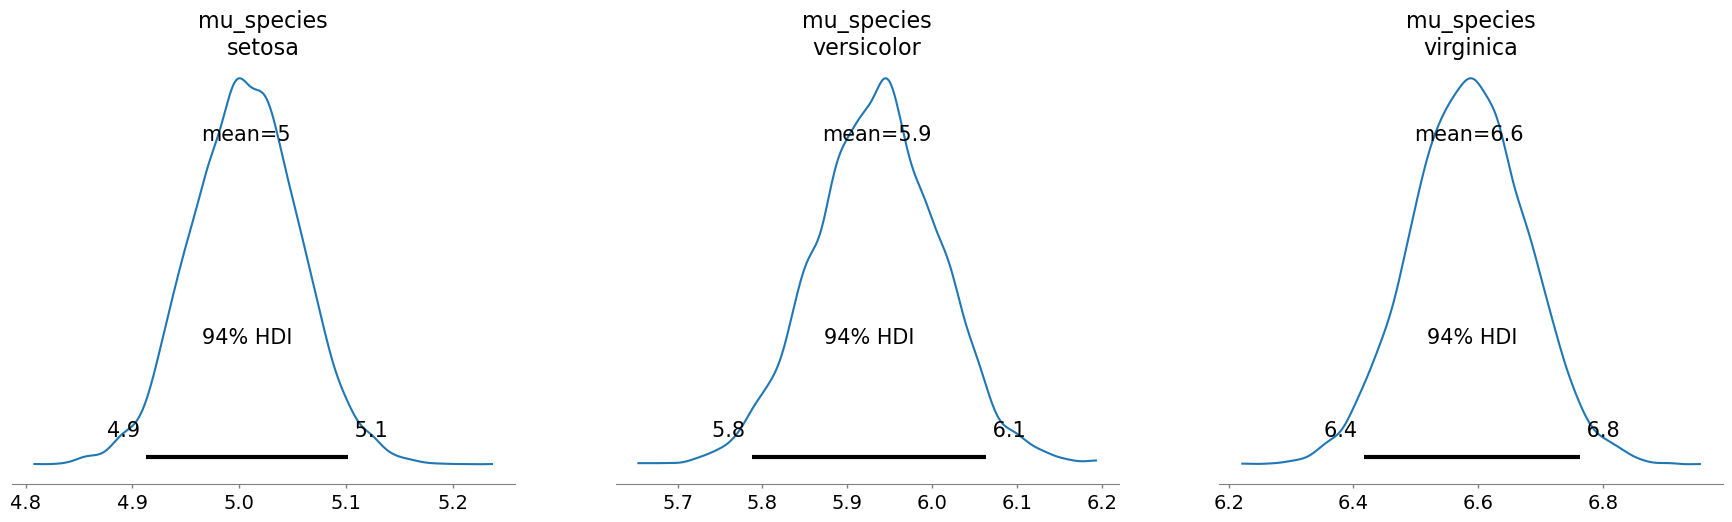

In [108]:
az.plot_posterior(trace_no_j, var_names=["mu_species"]);

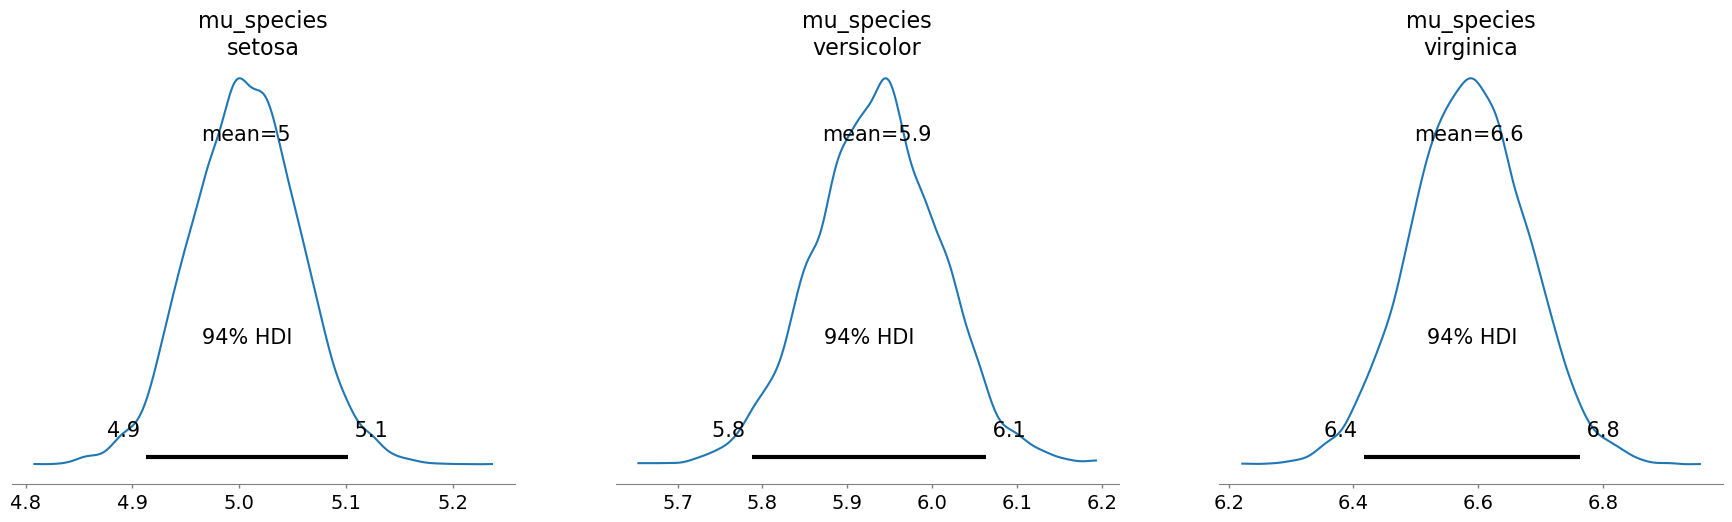

In [107]:
az.plot_posterior(trace_no_j, var_names=["mu_species"]);

En los tres casos (*setosa, versicolor y virginica*), las distribuciones posteriores de las medias son prácticamente iguales en el modelo jerárquico y en el no jerárquico.

- **Setosa:** la media posterior es de ~5.0 cm, con un intervalo creíble estrecho (4.9–5.1 cm). No se aprecian diferencias relevantes entre ambos modelos.  

- **Versicolor:** la media posterior es de ~5.9 cm, con intervalo 5.8–6.1 cm. El jerárquico y el no jerárquico coinciden casi exactamente.  

- **Virginica:** la media posterior es de ~6.6 cm, con intervalo 6.4–6.8 cm. Nuevamente, ambos modelos ofrecen estimaciones prácticamente idénticas.  

A continuacion procederemos a comparar las posterior con las medias observadas. Esto para tener un mejor analisis.

Tanto el modelo jerárquico como el no jerárquico estiman medias posteriores prácticamente idénticas para las tres especies, con intervalos de credibilidad estrechos que reflejan alta precisión. Además, en todos los casos las medias observadas coinciden muy bien con las distribuciones posteriores, lo que indica que los modelos capturan adecuadamente la estructura de los datos.

En este contexto, la gran cantidad de observaciones por especie y la clara separación entre las medias explican por qué el modelo jerárquico no aporta una contracción significativa respecto al no jerárquico. Ambos ofrecen resultados consistentes y confiables.

15. Observar si ocurre shrinkage (medias acercándose al promedio global).

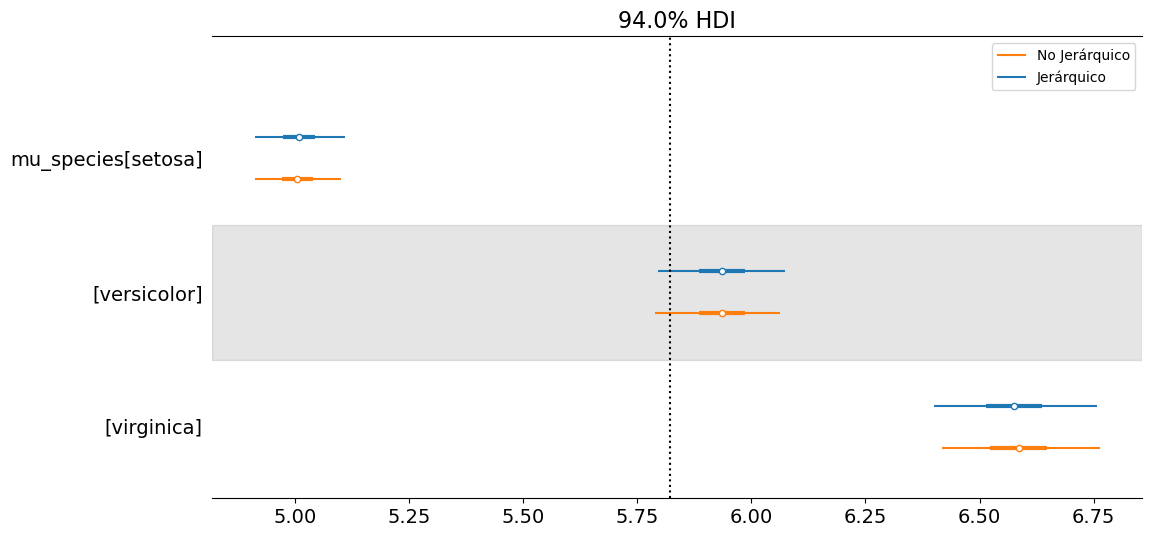

In [109]:
ax = az.plot_forest([trace_jer, trace_no_j], model_names=["Jerárquico", "No Jerárquico"],
               var_names=["mu_species"], combined=True, figsize=(12, 6))

y_lims = ax[0].get_ylim()

ax[0].vlines(trace_jer.posterior["mu_global"].mean(), *y_lims, colors='black', linestyles=':');

En este caso no se observa un shrinkage evidente. Las medias posteriores de *setosa* (5.0 cm), *versicolor* (5.9 cm) y *virginica* (6.6 cm) son prácticamente iguales en el modelo jerárquico y en el no jerárquico, y coinciden muy bien con las medias observadas. Esto se debe a que cada especie cuenta con una cantidad grande de datos (50 observaciones) y las medias están claramente separadas entre sí. Al haber tanta evidencia, el modelo jerárquico no necesita “tirar” las medias hacia la media global. En cambio, en situaciones con menos datos por grupo o con medias más cercanas, sí se esperaría ver el efecto de contracción característico de los modelos jerárquicos.


## Parte 3: Comparación y conclusiones
OBSERVACIÓN: Pueden realizar una comparación de modelos utilizando las siguien-
tes métricas de ajuste, o de forma manueal con alguna otra herramienta que consideren.


16. Calcular métricas de ajuste (WAIC o LOO) para comparar el modelo no jerárquico
vs jerárquico.

In [110]:
with non_hier_model:
    pm.compute_log_likelihood(trace_no_j, extend_inferencedata=True)

Output()

In [111]:
with hier_model:
    pm.compute_log_likelihood(trace_jer, extend_inferencedata=True)

Output()

In [112]:
az.compare({"Jerárquico": trace_jer, "No Jerárquico": trace_no_j})

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
No Jerárquico,0,-109.270893,5.244432,0.000000,1.0,8.494004,0.000000,False,log
Jerárquico,1,-109.525578,5.466382,0.254685,0.0,8.506271,0.111666,False,log


17. Discutir cuál modelo se ajusta mejor a los datos y por qué.

18. (Opcional) Usar ambos modelos para predecir nuevas observaciones (posterior pre-
dictivo) y comparar resultados.

In [113]:
with non_hier_model:
    pm.sample_posterior_predictive(trace_no_j, extend_inferencedata=True)

Sampling: [y_obs]


Output()

In [114]:
with hier_model:
    pm.sample_posterior_predictive(trace_jer, extend_inferencedata=True)

Sampling: [y_obs]


Output()

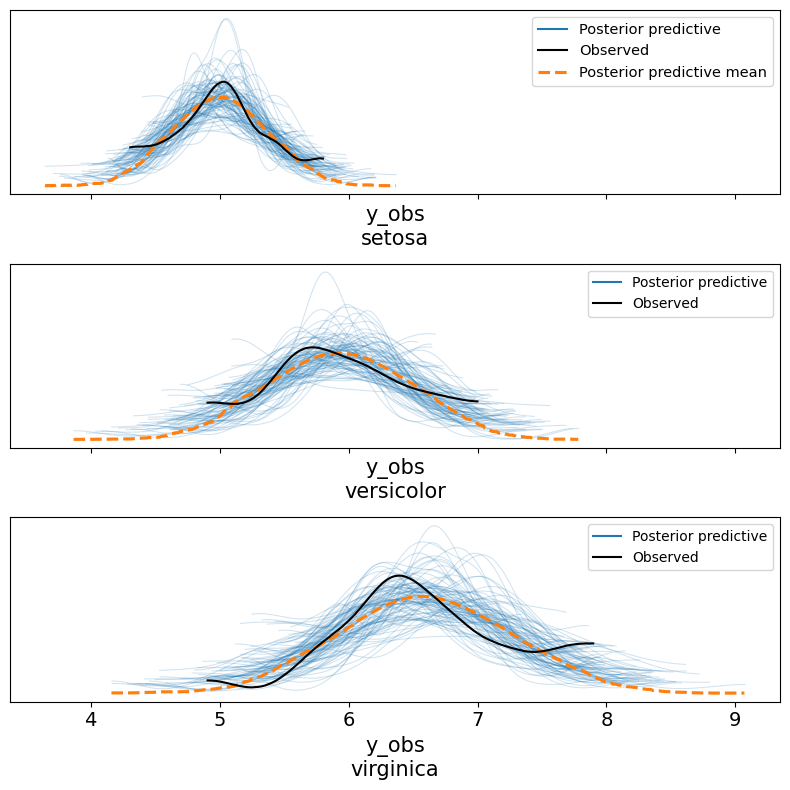

In [125]:
_, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)
az.plot_ppc(
    trace_no_j,
    num_pp_samples=100,
    coords={"species_flat": [categories]},
    flatten=[],
    ax=axes,
)
plt.tight_layout();

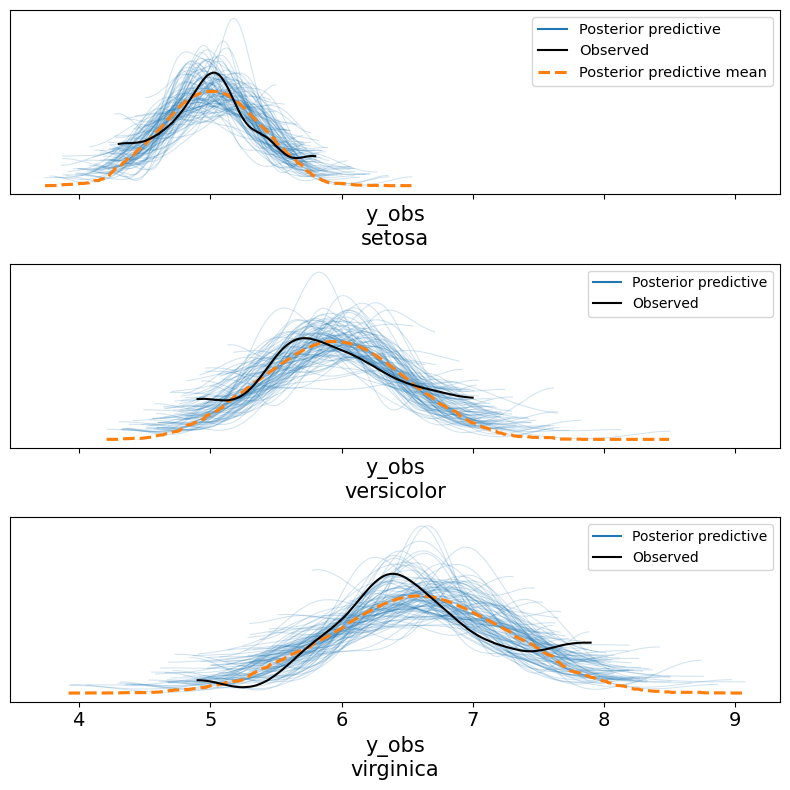

In [124]:
_, axes = plt.subplots(3, 1, figsize=(8, 8), sharex=True)

az.plot_ppc(
    trace_jer,
    num_pp_samples=100,
    coords={"species_flat": [categories]},
    flatten=[],
    ax=axes,
)
plt.tight_layout();

19. Resumir hallazgos del análisis exploratorio y del modelado bayesiano. Comentar
ventajas y limitaciones del enfoque jerárquico en este contexto.